## Supervised SimCSE

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [23]:
# Paths (modify if needed)
train_emb_path = "./data/allsides/embeddings/X_train_emb.npy"
train_lbl_path = "./data/allsides/embeddings/y_train.pkl"

test_emb_path = "./data/allsides/embeddings/X_test_emb.npy"
test_lbl_path = "./data/allsides/embeddings/y_test.pkl"

# Load embeddings
X_train = np.load(train_emb_path)
X_test = np.load(test_emb_path)

# Load labels
with open(train_lbl_path, "rb") as f:
    y_train = pickle.load(f)

with open(test_lbl_path, "rb") as f:
    y_test = pickle.load(f)
    
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print("Train:", X_train.shape, len(y_train))
print("Test :", X_test.shape, len(y_test))

Train: (994, 768) 994
Test : (1242, 768) 1242


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_2d = TSNE(n_components=2, random_state=42).fit_transform(X_emb)
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_labels, cmap='coolwarm', alpha=0.7)
plt.colorbar()
plt.show()

In [25]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds, target_names=le.classes_))

Random Forest Accuracy: 0.3389694041867955
              precision    recall  f1-score   support

      center       0.08      0.16      0.11       129
   lean left       0.16      0.18      0.17       155
  lean right       0.28      0.33      0.30       110
        left       0.54      0.44      0.48       593
       right       0.39      0.30      0.34       255

    accuracy                           0.34      1242
   macro avg       0.29      0.28      0.28      1242
weighted avg       0.39      0.34      0.36      1242



In [ ]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    objective="multi:softmax",
    num_class=len(np.unique(y_train)),
    # tree_method="gpu_hist",  # remove if not using GPU
    eval_metric="mlogloss",
    use_label_encoder=False
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds, target_names=le.classes_))

/home/hice1/nparikh44/scratch/miniconda/envs/simcse-h100/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [19:28:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Unsupervised SimCSE

In [1]:
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import pickle
import pandas as pd
from datasets import load_dataset

/home/hice1/nparikh44/scratch/miniconda/envs/simcse-h100/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_PATH = os.path.expanduser("~/scratch/experiments/simcse_political_unsup_roberta_base/_3_epochs") 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Loading model from:", MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModel.from_pretrained(MODEL_PATH).to(device)
model.eval()

Loading model from: /home/hice1/nparikh44/scratch/experiments/simcse_political_unsup_roberta_base/_3_epochs


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [3]:
print("Loading dataset...")
ds = load_dataset("lelouch0204/cleaned_allsides_v2.csv")
df = ds['train'].to_pandas()
print(f"Loaded: {len(df)} samples")

# Map bias labels (CORRECTED)
bias_mapping = {
    'left': 4,
    'lean left': 3,
    'center': 2,
    'lean right': 1,
    'right': 0
}
df['bias_label'] = df['Bias'].str.lower().str.strip().map(bias_mapping)
df = df.dropna(subset=['bias_label', 'Text'])
df['bias_label'] = df['bias_label'].astype(int)

# Use existing clean_text or Text
df['text_input'] = df['clean_text'].fillna(df['Text'])
df = df[df['text_input'].str.len() > 50]

print(f"Final dataset: {len(df)} samples")
print("Bias distribution:", df['bias_label'].value_counts().sort_index().to_dict())

# Train-test split
X_text = df['text_input'].values
y = df['bias_label'].values
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {len(X_train_text)}, Test: {len(X_test_text)}")

Loading dataset...
Loaded: 6209 samples
Final dataset: 6202 samples
Bias distribution: {0: 1273, 1: 549, 2: 644, 3: 776, 4: 2960}
Train: 4961, Test: 1241


In [4]:
def get_embeddings(texts, tokenizer, model, device, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            model_output = model(**encoded_input, output_hidden_states=False, return_dict=True)
            batch_embeddings = model_output.last_hidden_state[:,0,:].cpu().numpy()
            embeddings.append(batch_embeddings)
    return np.concatenate(embeddings, axis=0)

In [5]:
print("Generating train embeddings...")
X_train = get_embeddings(X_train_text.tolist(), tokenizer, model, device, batch_size=64)
y_train = y_train

print("Generating test embeddings...")
X_test = get_embeddings(X_test_text.tolist(), tokenizer, model, device, batch_size=64)
y_test = y_test

Generating train embeddings...


Encoding: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s]


Generating test embeddings...


Encoding: 100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


In [6]:
var = np.var(X_train)
print("Variance of training embeddings:", var)

if var < 1e-5:
    print("Warning: Low variance in embeddings may affect classifier performance.")

Variance of training embeddings: 0.4012719


In [7]:
print(f"Training Logistic Regression on {len(X_train)} samples...")
clf = LogisticRegression(max_iter=1000, C=1.0)
clf.fit(X_train, y_train)

Training Logistic Regression on 4961 samples...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)

In [9]:
print("\n" + "="*30)
print(f"Test Accuracy: {acc:.4f}")
print("="*30)
print(classification_report(y_test, preds))


Test Accuracy: 0.7905
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       255
           1       0.79      0.69      0.74       110
           2       0.75      0.80      0.77       129
           3       0.68      0.64      0.66       155
           4       0.82      0.85      0.84       592

    accuracy                           0.79      1241
   macro avg       0.77      0.75      0.76      1241
weighted avg       0.79      0.79      0.79      1241



In [19]:
## Function to plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
## classification metrics per class as a bar chart
def plot_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']
    
    # Prepare data for grouped bar plot
    data = []
    for class_name in class_names:
        for metric in metrics:
            data.append({
                'Class': class_name,
                'Metric': metric.capitalize(),
                'Value': report[class_name][metric]
            })
    
    df = pd.DataFrame(data)
    
    # Create single plot with grouped bars
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Class', y='Value', hue='Metric')
    plt.ylim(0, 1)
    plt.title('Classification Metrics per Class')
    plt.ylabel('Score')
    plt.xlabel('Class')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()
        
## AUC-ROC curve plotting for multi-class classification
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(y_true, y_pred_proba, class_names):
    y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = y_true_binarized.shape[1]
    
    plt.figure(figsize=(8,6))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

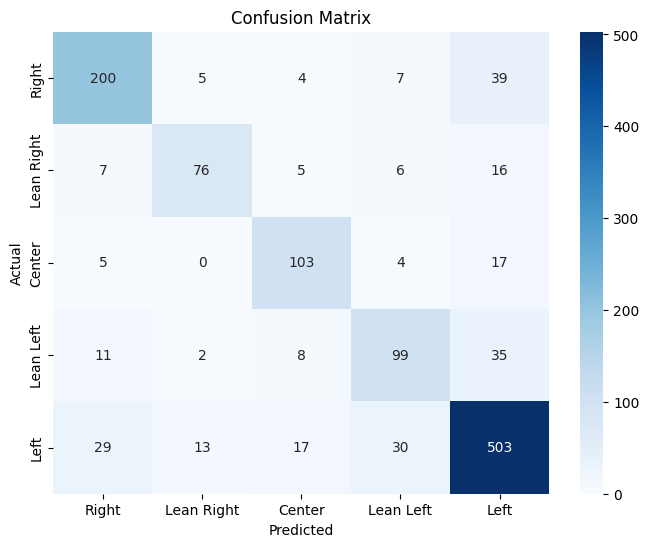

In [20]:
plot_confusion_matrix(y_test, preds, class_names=['Right', 'Lean Right', 'Center', 'Lean Left', 'Left'])

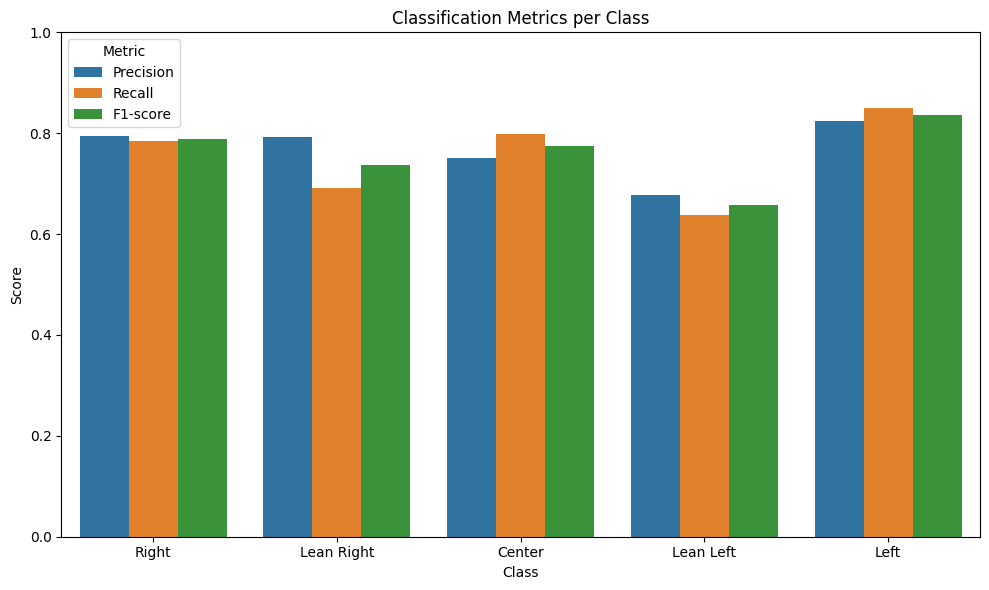

In [21]:
plot_classification_report(y_test, preds, class_names=['Right', 'Lean Right', 'Center', 'Lean Left', 'Left'])

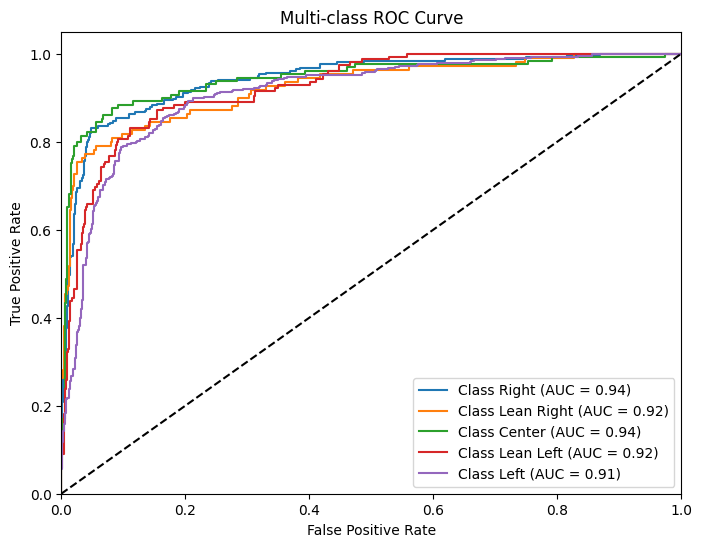

In [22]:
plot_roc_curve(y_test, clf.predict_proba(X_test), class_names=['Right', 'Lean Right', 'Center', 'Lean Left', 'Left'])

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf_balanced = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=3000, 
        class_weight='balanced',
        n_jobs=-1
    )
)
clf_balanced.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [24]:
preds = clf_balanced.predict(X_test)
acc = accuracy_score(y_test, preds)

In [25]:
print("\n" + "="*30)
print(f"Test Accuracy: {acc:.4f}")
print("="*30)
print(classification_report(y_test, preds))


Test Accuracy: 0.7865
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       255
           1       0.68      0.74      0.71       110
           2       0.70      0.88      0.78       129
           3       0.65      0.76      0.70       155
           4       0.89      0.77      0.82       592

    accuracy                           0.79      1241
   macro avg       0.74      0.79      0.76      1241
weighted avg       0.80      0.79      0.79      1241



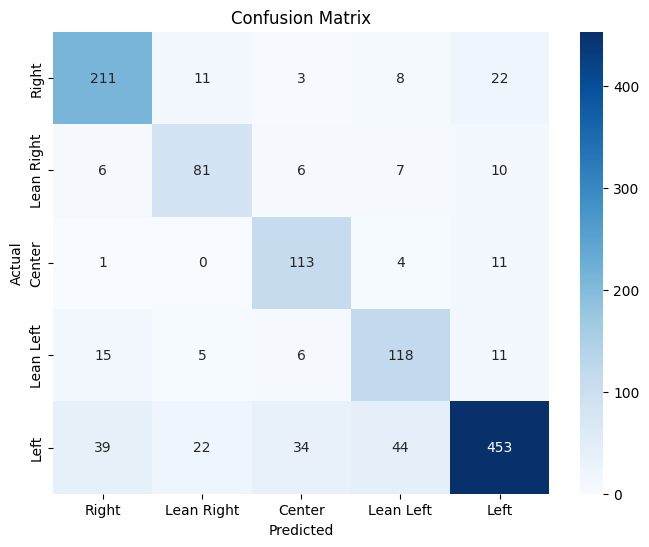

In [26]:
plot_confusion_matrix(y_test, preds, class_names=['Right', 'Lean Right', 'Center', 'Lean Left', 'Left'])

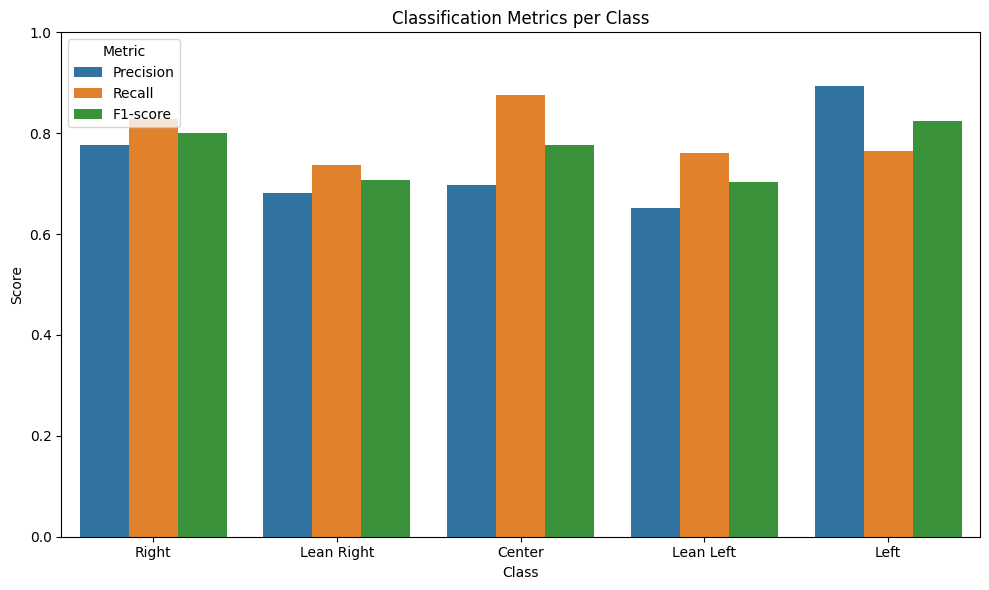

In [27]:
plot_classification_report(y_test, preds, class_names=['Right', 'Lean Right', 'Center', 'Lean Left', 'Left'])

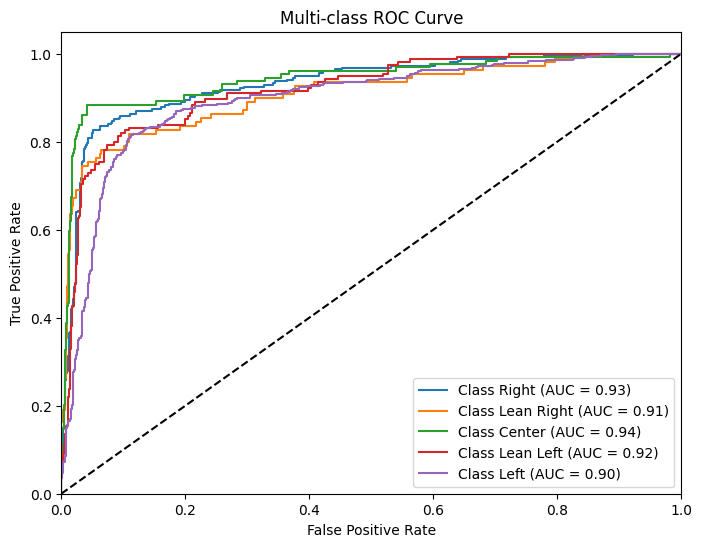

In [29]:
plot_roc_curve(y_test, clf_balanced.predict_proba(X_test), class_names=['Right', 'Lean Right', 'Center', 'Lean Left', 'Left'])